# Inspect Pretrained DeepLabV3

In this notebook, we explore the DeepLabV3 models provided in the PyTorch module `torchvision.models.segmentation.deeplabv3`. The findings informed our design of the custom PyTorch Lightning module `models.DeepLabV3ImageSegmenter`, which we use for fine-tuning DeepLabV3 models for the main experiments.

https://pytorch.org/vision/stable/models/deeplabv3.html  
https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/  
https://learnopencv.com/deeplabv3-ultimate-guide/  
https://debuggercafe.com/semantic-segmentation-using-pytorch-deeplabv3-resnet50/  

In [1]:
# Standard
from enum import Enum
import os
from typing import Any, Callable, Dict, List, Tuple

# Numerics
import numpy as np

# Image Processing
import cv2
import imageio.v3 as imageio

# Machine Learning
import torch
import torch.nn as nn
#
from torchvision.models.segmentation import deeplabv3
import albumentations as albm  # Faster than `torchvision.transforms`.
#
import torchinfo  # For `torchinfo.summary`.

In [2]:
# Project-Specific
from core import (
    eda,
    ema,
    SemanticClassMapping,
    SparseLabelSimulatingDataset,
)
from core.visualization import (
    scale_plot_size,
    show_image,
    overlay_segmentation_map_rgb,
)
from data.cityscapes import (
    cityscapes_dataset,
    class_mapping as cityscapes_class_mapping,
    preprocesses_from,
)
# The pretrained DeepLabV3 uses Pascal VOC classes.
from data.pascal_voc import class_mapping as pascal_voc_class_mapping

In [3]:
scale_plot_size(factor=1.8)

In [4]:
# Manually seed for reproducibility.
np.random.seed(13)
torch.manual_seed(13)

In [5]:
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


---

## Load Pretrained DeepLabV3

These PyTorch DeepLabV3 models have been trained on COCO dataset with the 20+1 classes of Pascal VOC  
(rather than the native classes of COCO):  
```
['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
```

Models download to  
`~/.cache/torch/hub/checkpoints/*.pth`

In [6]:
#dir(deeplabv3)

In [7]:
# S (Small)
model_from_s: Callable = \
    deeplabv3.deeplabv3_mobilenet_v3_large  # ~43 MB, ~11 M parameters.
weights_s: Enum = deeplabv3.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model_s: nn.Module = model_from_s(weights=weights_s)
model_s.aux_classifier = None  # Remove auxiliary classifier.
ema.print_model_stats(model_s, model_name="S")

_S Model Statistics_
Number of parameters: 11_025_477
Number of trainable parameters: 11_025_477


In [8]:
torchinfo.summary(model_s.classifier)

Layer (type:depth-idx)                        Param #
DeepLabHead                                   --
├─ASPP: 1-1                                   --
│    └─ModuleList: 2-1                        --
│    │    └─Sequential: 3-1                   246,272
│    │    └─ASPPConv: 3-2                     2,212,352
│    │    └─ASPPConv: 3-3                     2,212,352
│    │    └─ASPPConv: 3-4                     2,212,352
│    │    └─ASPPPooling: 3-5                  246,272
│    └─Sequential: 2-2                        --
│    │    └─Conv2d: 3-6                       327,680
│    │    └─BatchNorm2d: 3-7                  512
│    │    └─ReLU: 3-8                         --
│    │    └─Dropout: 3-9                      --
├─Conv2d: 1-2                                 589,824
├─BatchNorm2d: 1-3                            512
├─ReLU: 1-4                                   --
├─Conv2d: 1-5                                 5,397
Total params: 8,053,525
Trainable params: 8,053,525
Non-trainable p

In [9]:
# M (Medium)
model_from_m: Callable = \
    deeplabv3.deeplabv3_resnet50  # ~161 MB , ~42 M parameters
weights_m: Enum = deeplabv3.DeepLabV3_ResNet50_Weights.DEFAULT
model_m: nn.Module = model_from_m(weights=weights_m)
model_m.aux_classifier = None  # Remove auxiliary classifier.
ema.print_model_stats(model_m, model_name="M")

_M Model Statistics_
Number of parameters: 39_638_869
Number of trainable parameters: 39_638_869


In [10]:
torchinfo.summary(model_m.classifier)

Layer (type:depth-idx)                        Param #
DeepLabHead                                   --
├─ASPP: 1-1                                   --
│    └─ModuleList: 2-1                        --
│    │    └─Sequential: 3-1                   524,800
│    │    └─ASPPConv: 3-2                     4,719,104
│    │    └─ASPPConv: 3-3                     4,719,104
│    │    └─ASPPConv: 3-4                     4,719,104
│    │    └─ASPPPooling: 3-5                  524,800
│    └─Sequential: 2-2                        --
│    │    └─Conv2d: 3-6                       327,680
│    │    └─BatchNorm2d: 3-7                  512
│    │    └─ReLU: 3-8                         --
│    │    └─Dropout: 3-9                      --
├─Conv2d: 1-2                                 589,824
├─BatchNorm2d: 1-3                            512
├─ReLU: 1-4                                   --
├─Conv2d: 1-5                                 5,397
Total params: 16,130,837
Trainable params: 16,130,837
Non-trainable

In [11]:
# L (Large)
model_from_l: Callable = \
    deeplabv3.deeplabv3_resnet101  # ~234 MB, ~60 M parameters.
weights_l: Enum = deeplabv3.DeepLabV3_ResNet101_Weights.DEFAULT
model_l: nn.Module = model_from_l(weights=weights_l)
model_l.aux_classifier = None  # Remove auxiliary classifier.
ema.print_model_stats(model_l, model_name="L")

_L Model Statistics_
Number of parameters: 58_630_997
Number of trainable parameters: 58_630_997


In [12]:
torchinfo.summary(model_l.classifier)

Layer (type:depth-idx)                        Param #
DeepLabHead                                   --
├─ASPP: 1-1                                   --
│    └─ModuleList: 2-1                        --
│    │    └─Sequential: 3-1                   524,800
│    │    └─ASPPConv: 3-2                     4,719,104
│    │    └─ASPPConv: 3-3                     4,719,104
│    │    └─ASPPConv: 3-4                     4,719,104
│    │    └─ASPPPooling: 3-5                  524,800
│    └─Sequential: 2-2                        --
│    │    └─Conv2d: 3-6                       327,680
│    │    └─BatchNorm2d: 3-7                  512
│    │    └─ReLU: 3-8                         --
│    │    └─Dropout: 3-9                      --
├─Conv2d: 1-2                                 589,824
├─BatchNorm2d: 1-3                            512
├─ReLU: 1-4                                   --
├─Conv2d: 1-5                                 5,397
Total params: 16,130,837
Trainable params: 16,130,837
Non-trainable

In [13]:
#dir(modelL.classifier)

In [14]:
# Show downloaded models with sizes.
!du -sh ~/.cache/torch/hub/checkpoints/* | sort -h

22M	/home/karl/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
43M	/home/karl/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
161M	/home/karl/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
234M	/home/karl/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
528M	/home/karl/.cache/torch/hub/checkpoints/vgg16-397923af.pth
549M	/home/karl/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [15]:
# Show some additional info only for the large model.
param: nn.Parameter = next(model_l.parameters())
print(type(param))

<class 'torch.nn.parameter.Parameter'>


In [16]:
torchinfo.summary(model_l)

Layer (type:depth-idx)                             Param #
DeepLabV3                                          --
├─IntermediateLayerGetter: 1-1                     --
│    └─Conv2d: 2-1                                 9,408
│    └─BatchNorm2d: 2-2                            128
│    └─ReLU: 2-3                                   --
│    └─MaxPool2d: 2-4                              --
│    └─Sequential: 2-5                             --
│    │    └─Bottleneck: 3-1                        75,008
│    │    └─Bottleneck: 3-2                        70,400
│    │    └─Bottleneck: 3-3                        70,400
│    └─Sequential: 2-6                             --
│    │    └─Bottleneck: 3-4                        379,392
│    │    └─Bottleneck: 3-5                        280,064
│    │    └─Bottleneck: 3-6                        280,064
│    │    └─Bottleneck: 3-7                        280,064
│    └─Sequential: 2-7                             --
│    │    └─Bottleneck: 3-8              

In [17]:
#dir(model_l.backbone)

In [18]:
#torchinfo.summary(model_l.backbone)

---

## Load Cityscapes Data

Even though the Cityscapes data has labels different from Pascal VOC, we use it in this notebook for smoke-testing the model because we already have it available for our separate fine-tuning objective.

In [19]:
PROJECT_ROOT: str = os.environ.get("PROJECT_ROOT")
assert PROJECT_ROOT is not None, \
    "PROJECT_ROOT not found! Did you run `setenv.sh` before serving the notebook?"
data_root_dirname: str = os.path.join(PROJECT_ROOT, "data/cityscapes")

In [20]:
!ls -Fal {data_root_dirname}

total 11567320
drwxr-xr-x 4 karl karl        4096 Jan  1 19:48 ./
drwxr-xr-x 3 karl karl        4096 Jan  1 19:48 ../
-rw-r--r-- 1 karl karl           0 Jan  1 19:29 .gitkeep
drwxr-xr-x 5 karl karl        4096 Jan  1 19:48 gtFine/
-rw-r--r-- 1 karl karl   252567705 Mar 21  2016 gtFine_trainvaltest.zip
drwxr-xr-x 5 karl karl        4096 Jan  1 19:49 leftImg8bit/
-rw-r--r-- 1 karl karl 11592327197 Mar 21  2016 leftImg8bit_trainvaltest.zip
-rw-r--r-- 1 karl karl        1646 Feb 17  2016 license.txt
-rw-r--r-- 1 karl karl         298 Feb 20  2016 README


In [21]:
preprocesses: Dict[str, albm.Compose] = preprocesses_from(
    input_height=320,
    input_width=640,
    mean_for_input_normalization=(0.485, 0.456, 0.406),
    std_for_input_normalization=(0.229, 0.224, 0.225),
    #do_shift_scale_rotate=...,  # Not relevant here since we're only using
    #ignore_index=...,           # the "infer" preprocessing.
)

In [22]:
dataset: SparseLabelSimulatingDataset = cityscapes_dataset(
    split="val",
    preprocess=preprocesses["infer"],
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
)

---

## Demo Inference

In [23]:
# Choose just one of the pretrained models to demo inference with.
model: nn.Module = model_l

In [24]:
# Preprocessing transforms image to model input.
preprocess = preprocesses["infer"]
type(preprocess).mro()

[albumentations.core.composition.Compose,
 albumentations.core.composition.BaseCompose,
 albumentations.core.serialization.Serializable,
 object]

In [25]:
next(model.parameters()).device

device(type='cpu')

In [26]:
model.to(device)
model.eval();

In [27]:
next(model.parameters()).device

device(type='cuda', index=0)

101
type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


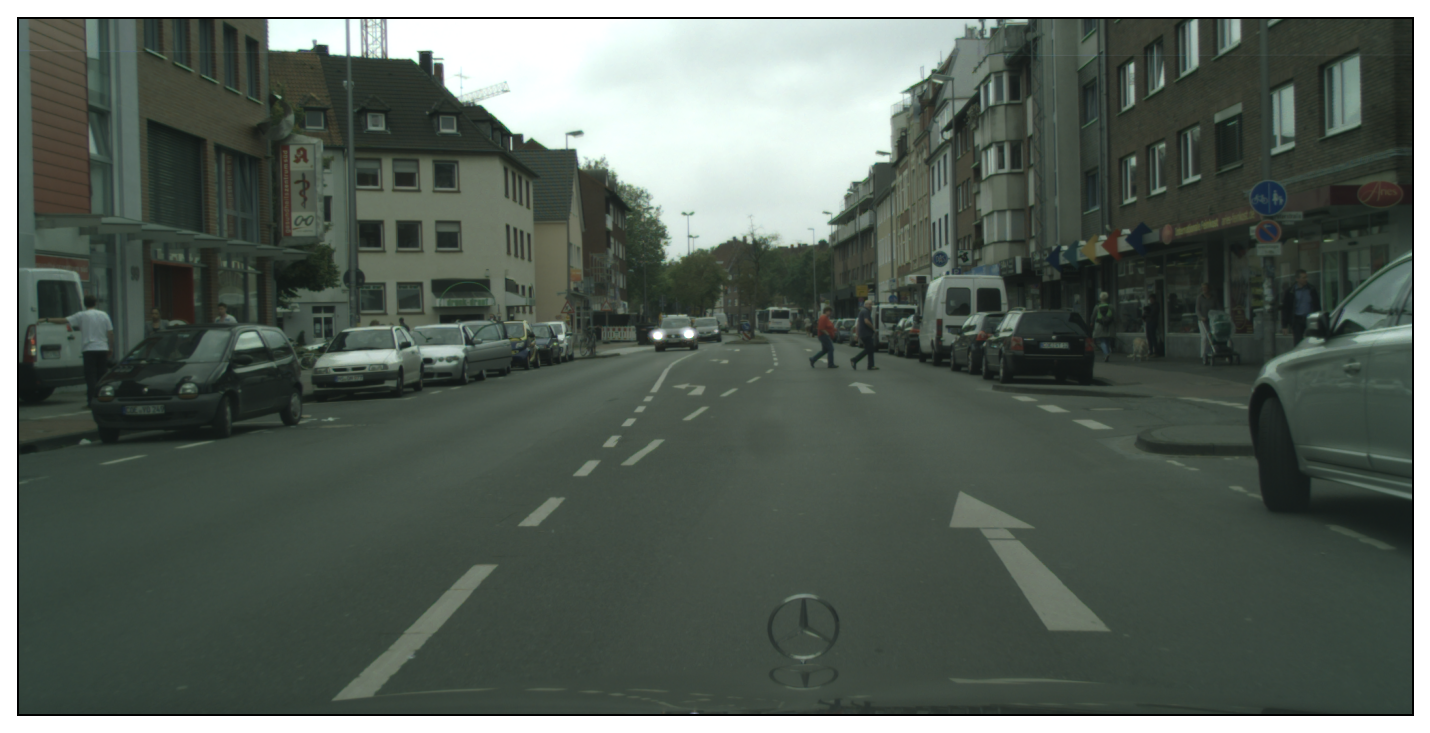

In [28]:
# Pick an image to feed to the model.
ix: int = 101
# ix: int = np.random.randint(low=0, high=len(dataset))
print(ix)
datapair_unpreprocessed: Tuple[np.ndarray, np.ndarray] = \
    dataset.get_unpreprocessed(ix)
image: np.ndarray = datapair_unpreprocessed[0]
segmentation_map_int_target: np.ndarray = datapair_unpreprocessed[1]
eda.print_image_metadata(image)
show_image(image)

type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048)


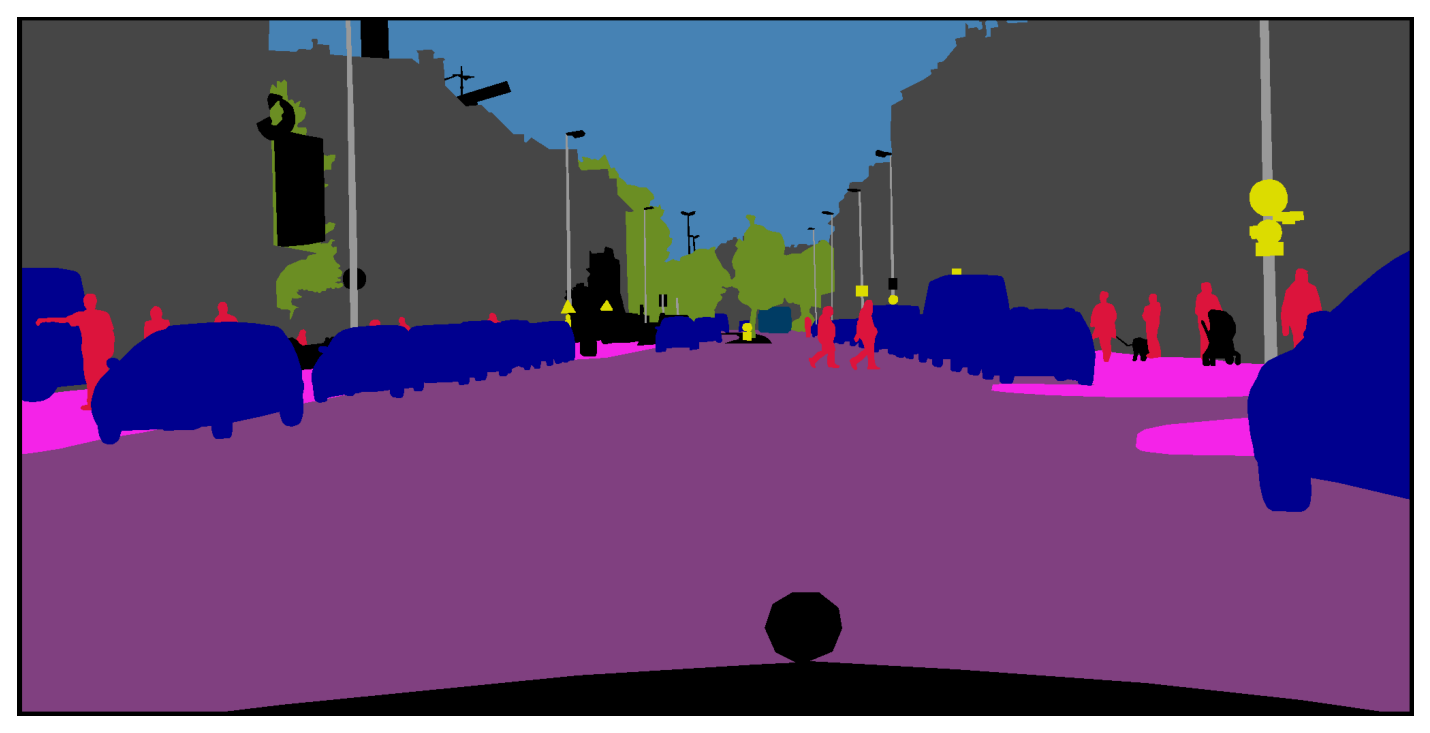

In [29]:
# Here we look at the Cityscapes segmentation map just for comparison.
# Remember that the classes here are different than those of Pascal VOC
# output by the model.
segmentation_map_rgb_target: np.array = \
    cityscapes_class_mapping.segmentation_map_rgb_from_int(
        segmentation_map_int_target,
    )
eda.print_image_metadata(segmentation_map_int_target)
show_image(segmentation_map_rgb_target)

### Pass Preprocessed Input Through Model

In [30]:
height_raw: int = image.shape[0]
width_raw: int = image.shape[1]

In [31]:
def segment(
    image: np.ndarray,
    model: nn.Module,
    device: torch.device,
    preprocess: albm.Compose,
    class_mapping: SemanticClassMapping,
) -> np.ndarray:
    height_raw: int = image.shape[0]
    width_raw: int = image.shape[1]
    image_tensor: torch.Tensor = preprocess(image=image)["image"].to(device)
    minibatch: torch.Tensor = image_tensor.unsqueeze(0)
    model.eval()
    with torch.inference_mode():
        segmentation_map_logits: torch.Tensor = model(minibatch)["out"][0]
    segmentation_map_int: np.ndarray = \
        class_mapping.segmentation_map_int_from_logits(segmentation_map_logits)
    segmentation_map_int: np.ndarray = cv2.resize(
        segmentation_map_int,
        (width_raw, height_raw),
        interpolation=cv2.INTER_NEAREST,
    )
    return segmentation_map_int

In [32]:
segmentation_map_int_ref: np.ndarray = \
    segment(image, model, device, preprocess, pascal_voc_class_mapping)

In [33]:
# The next 3 cells are equivalent to calling the `segment` function,
# but we break it down to inspect itermediate values.

In [34]:
image_tensor: torch.Tensor = preprocess(image=image)["image"].to(device)

In [35]:
minibatch: torch.Tensor = image_tensor.unsqueeze(0)  # Add minibatch dimension.

In [36]:
minibatch.shape

torch.Size([1, 3, 320, 640])

In [37]:
model_output_raw: Dict[str, torch.Tensor] = model(minibatch)
segmentation_map_logits: torch.Tensor = model_output_raw["out"][0]
segmentation_map_categorical: torch.Tensor = \
    torch.softmax(segmentation_map_logits, dim=0)
# Equivalent to `segmentation_map_logits = model(minibatch)["out"].squeeze()`.

In [38]:
segmentation_map_int: np.ndarray = \
    pascal_voc_class_mapping.segmentation_map_int_from_categorical(
        segmentation_map_categorical,
    )

In [39]:
segmentation_map_int: np.ndarray = cv2.resize(
    segmentation_map_int,
    (width_raw, height_raw),
    interpolation=cv2.INTER_NEAREST,
)

In [40]:
# Confirm that we got the same result.
assert np.all(segmentation_map_int == segmentation_map_int_ref)

### Inspect Intermediate Values

In [41]:
type(model_output_raw).mro()

[collections.OrderedDict, dict, object]

In [42]:
model_output_raw.keys()

odict_keys(['out'])

In [43]:
type(model_output_raw["out"])

torch.Tensor

In [44]:
model_output_raw["out"].shape

torch.Size([1, 21, 320, 640])

In [45]:
type(segmentation_map_logits)

torch.Tensor

In [46]:
segmentation_map_logits.shape

torch.Size([21, 320, 640])

In [47]:
segmentation_map_logits.dtype

torch.float32

In [48]:
segmentation_map_logits.device

device(type='cuda', index=0)

In [49]:
type(segmentation_map_categorical)

torch.Tensor

In [50]:
segmentation_map_categorical.shape

torch.Size([21, 320, 640])

In [51]:
segmentation_map_categorical.dtype

torch.float32

In [52]:
segmentation_map_categorical.device

device(type='cuda', index=0)

### Visualize

In [53]:
if False:
    import torchviz
    #x = torch.randn(1, 3, height, width)
    #y = model(x)
    dot: Any = torchviz.make_dot(
        model_output_raw["out"],
        params=dict(model.named_parameters()),
    )
    dot_filename: str = "model_architecture.dot"
    dot.render(filename=dot_filename, format="png")
    dot.render(filename=dot_filename, format="eps")
    dot.render(filename=dot_filename, format="pdf")

In [54]:
if False:
    model_architecture_image_filename: str = dot_filename + ".png"
    model_architecture_image: str = \
        imageio.imread(model_architecture_image_filename)
    show_image(model_architecture_image)

In [55]:
segmentation_map_int: np.ndarray = cv2.resize(
   segmentation_map_int,
   (width_raw, height_raw),
   interpolation=cv2.INTER_NEAREST,
)
eda.print_image_metadata(segmentation_map_int)

type: <class 'numpy.ndarray'>
dtype: int32
shape: (1024, 2048)


In [56]:
pixel_stats: eda.SegmentationMapPixelStats = \
    eda.SegmentationMapPixelStats(segmentation_map_int)
pixel_stats.print_summary(pascal_voc_class_mapping)

+----------+------------+----------+-----------+
| class ID | class name | # pixels |  portion  |
|          |            |          | of pixels |
+==========+============+==========+===========+
|    0     | background | 1943121  |   0.927   |
+----------+------------+----------+-----------+
|    7     |    car     |  147694  |   0.070   |
+----------+------------+----------+-----------+
|    15    |   person   |   6337   |   0.003   |
+----------+------------+----------+-----------+


In [57]:
segmentation_map_rgb: np.ndarray = \
    pascal_voc_class_mapping.segmentation_map_rgb_from_int(segmentation_map_int)

type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


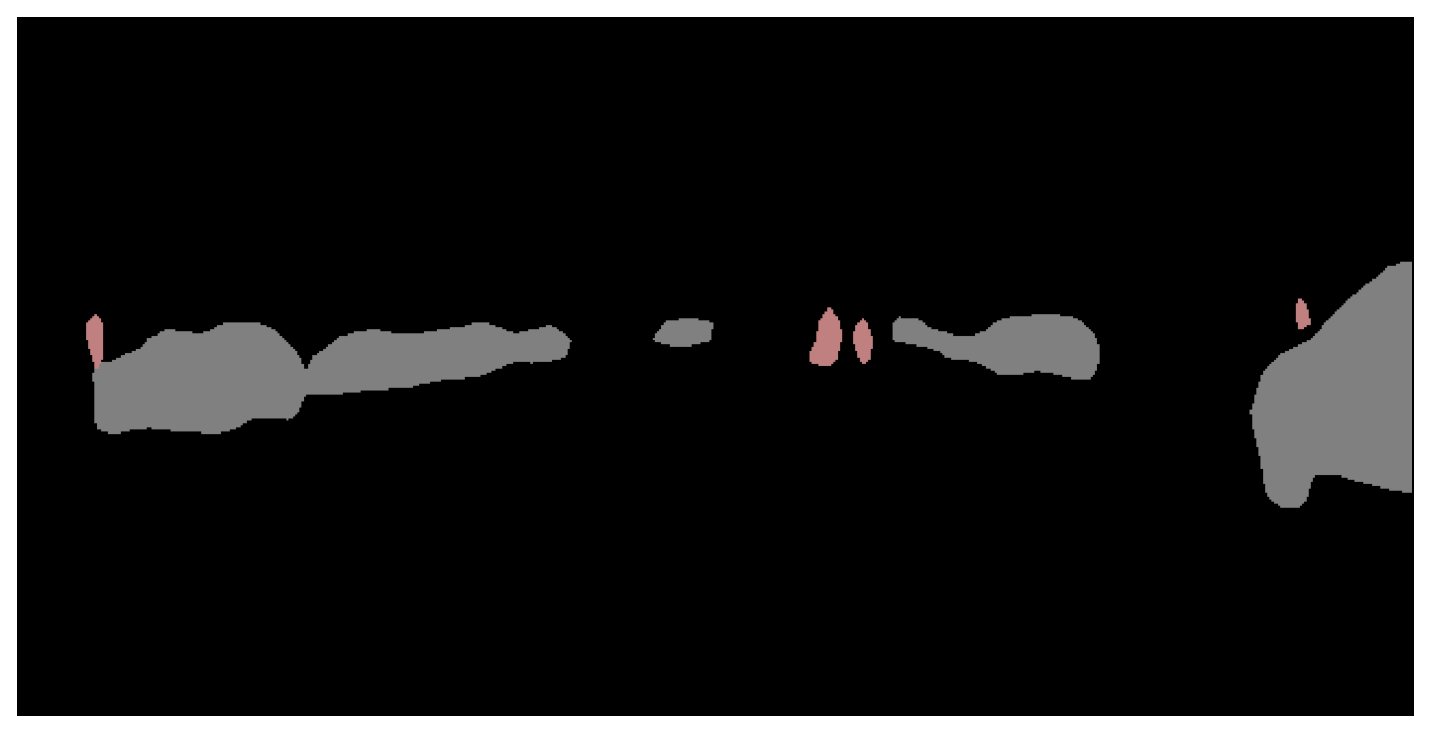

In [58]:
eda.print_image_metadata(segmentation_map_rgb)
show_image(segmentation_map_rgb)

type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


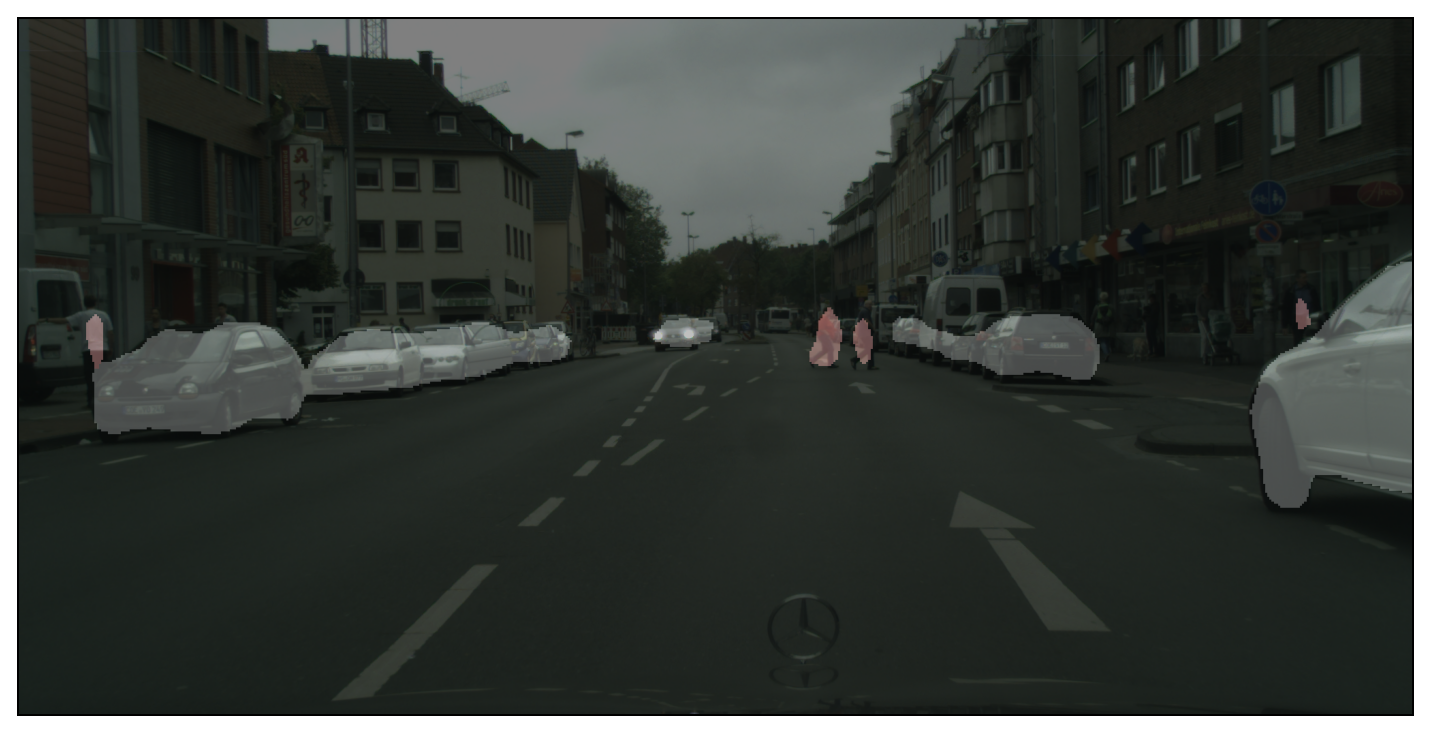

In [59]:
image_with_overlay: np.ndarray = \
    overlay_segmentation_map_rgb(image, segmentation_map_rgb, alpha=0.5)
eda.print_image_metadata(image_with_overlay)
show_image(image_with_overlay)

---

## Demo Extraction of Final vs Non-Final-Layer Parameters

This is useful for assigning different learning rates to different layers.

In [60]:
torchinfo.summary(model.classifier[4])

Layer (type:depth-idx)                   Param #
Conv2d                                   5,397
Total params: 5,397
Trainable params: 5,397
Non-trainable params: 0

In [61]:
param_names = [ name for name, _ in model.named_parameters() ]
len(param_names)

335

In [62]:
param_names[:5]

['backbone.conv1.weight',
 'backbone.bn1.weight',
 'backbone.bn1.bias',
 'backbone.layer1.0.conv1.weight',
 'backbone.layer1.0.bn1.weight']

In [63]:
param_names[-5:]

['classifier.1.weight',
 'classifier.2.weight',
 'classifier.2.bias',
 'classifier.4.weight',
 'classifier.4.bias']

In [64]:
# Final-layer parameters.
pf: List[nn.Parameter] = list(model.classifier[4].parameters())
len(pf)

2

In [65]:
pf_numel: int = sum(item.numel() for item in pf)
print(pf_numel)

5397


In [66]:
# Non-final-layer parameters.
pnf: List[nn.Parameter] = [
    param for name, param in model.named_parameters()
    if param.requires_grad and ("classifier.4" not in name)
]
len(pnf)

333

In [67]:
pnf_numel: int = sum(item.numel() for item in pnf)
print(pnf_numel)

58625600


In [68]:
assert sum(param.numel() for param in model.parameters()) == pnf_numel + pf_numel